100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:49<00:00,  5.80s/it]


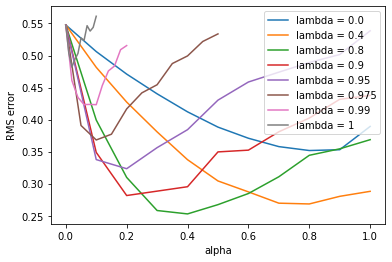

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


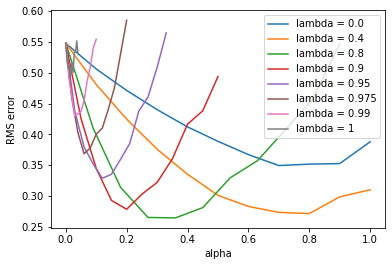

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:00<00:00,  2.40s/it]


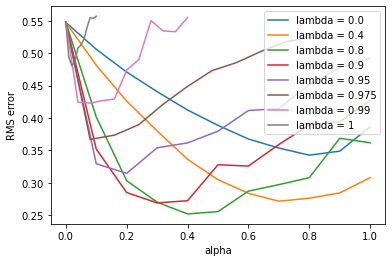

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from tqdm import tqdm

# all states
N_STATES = 19

# all states but terminal states
STATES = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state values from Bellman equation
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[N_STATES + 1] = 0.0

# base class for lambda-based algorithms in this chapter
# In this example, we use the simplest linear feature function, state aggregation.
# And we use exact 19 groups, so the weights for each group is exact the value for that state
class ValueFunction:
    # @rate: lambda, as it's a keyword in python, so I call it rate
    # @stepSize: alpha, step size for update
    def __init__(self, rate, step_size):
        self.rate = rate
        self.step_size = step_size
        self.weights = np.zeros(N_STATES + 2)

    # the state value is just the weight
    def value(self, state):
        return self.weights[state]

    # feed the algorithm with new observation
    # derived class should override this function
    def learn(self, state, reward):
        return

    # initialize some variables at the beginning of each episode
    # must be called at the very beginning of each episode
    # derived class should override this function
    def new_episode(self):
        return

# Off-line lambda-return algorithm
class OffLineLambdaReturn(ValueFunction):
    def __init__(self, rate, step_size):
        ValueFunction.__init__(self, rate, step_size)
        # To accelerate learning, set a truncate value for power of lambda
        self.rate_truncate = 1e-3

    def new_episode(self):
        # initialize the trajectory
        self.trajectory = [START_STATE]
        # only need to track the last reward in one episode, as all others are 0
        self.reward = 0.0

    def learn(self, state, reward):
        # add the new state to the trajectory
        self.trajectory.append(state)
        if state in END_STATES:
            # start off-line learning once the episode ends
            self.reward = reward
            self.T = len(self.trajectory) - 1
            self.off_line_learn()

    # get the n-step return from the given time
    def n_step_return_from_time(self, n, time):
        # gamma is always 1 and rewards are zero except for the last reward
        # the formula can be simplified
        end_time = min(time + n, self.T)
        returns = self.value(self.trajectory[end_time])
        if end_time == self.T:
            returns += self.reward
        return returns

    # get the lambda-return from the given time
    def lambda_return_from_time(self, time):
        returns = 0.0
        lambda_power = 1
        for n in range(1, self.T - time):
            returns += lambda_power * self.n_step_return_from_time(n, time)
            lambda_power *= self.rate
            if lambda_power < self.rate_truncate:
                # If the power of lambda has been too small, discard all the following sequences
                break
        returns *= 1 - self.rate
        if lambda_power >= self.rate_truncate:
            returns += lambda_power * self.reward
        return returns

    # perform off-line learning at the end of an episode
    def off_line_learn(self):
        for time in range(self.T):
            # update for each state in the trajectory
            state = self.trajectory[time]
            delta = self.lambda_return_from_time(time) - self.value(state)
            delta *= self.step_size
            self.weights[state] += delta

# TD(lambda) algorithm
class TemporalDifferenceLambda(ValueFunction):
    def __init__(self, rate, step_size):
        ValueFunction.__init__(self, rate, step_size)
        self.new_episode()

    def new_episode(self):
        # initialize the eligibility trace
        self.eligibility = np.zeros(N_STATES + 2)
        # initialize the beginning state
        self.last_state = START_STATE

    def learn(self, state, reward):
        # update the eligibility trace and weights
        self.eligibility *= self.rate
        self.eligibility[self.last_state] += 1
        delta = reward + self.value(state) - self.value(self.last_state)
        delta *= self.step_size
        self.weights += delta * self.eligibility
        self.last_state = state

# True online TD(lambda) algorithm
class TrueOnlineTemporalDifferenceLambda(ValueFunction):
    def __init__(self, rate, step_size):
        ValueFunction.__init__(self, rate, step_size)

    def new_episode(self):
        # initialize the eligibility trace
        self.eligibility = np.zeros(N_STATES + 2)
        # initialize the beginning state
        self.last_state = START_STATE
        # initialize the old state value
        self.old_state_value = 0.0

    def learn(self, state, reward):
        # update the eligibility trace and weights
        last_state_value = self.value(self.last_state)
        state_value = self.value(state)
        dutch = 1 - self.step_size * self.rate * self.eligibility[self.last_state]
        self.eligibility *= self.rate
        self.eligibility[self.last_state] += dutch
        delta = reward + state_value - last_state_value
        self.weights += self.step_size * (delta + last_state_value - self.old_state_value) * self.eligibility
        self.weights[self.last_state] -= self.step_size * (last_state_value - self.old_state_value)
        self.old_state_value = state_value
        self.last_state = state

# 19-state random walk
def random_walk(value_function):
    value_function.new_episode()
    state = START_STATE
    while state not in END_STATES:
        next_state = state + np.random.choice([-1, 1])
        if next_state == 0:
            reward = -1
        elif next_state == N_STATES + 1:
            reward = 1
        else:
            reward = 0
        value_function.learn(next_state, reward)
        state = next_state

# general plot framework
# @valueFunctionGenerator: generate an instance of value function
# @runs: specify the number of independent runs
# @lambdas: a series of different lambda values
# @alphas: sequences of step size for each lambda
def parameter_sweep(value_function_generator, runs, lambdas, alphas):
    # play for 10 episodes for each run
    episodes = 10
    # track the rms errors
    errors = [np.zeros(len(alphas_)) for alphas_ in alphas]
    for run in tqdm(range(runs)):
        for lambdaIndex, rate in enumerate(lambdas):
            for alphaIndex, alpha in enumerate(alphas[lambdaIndex]):
                valueFunction = value_function_generator(rate, alpha)
                for episode in range(episodes):
                    random_walk(valueFunction)
                    stateValues = [valueFunction.value(state) for state in STATES]
                    errors[lambdaIndex][alphaIndex] += np.sqrt(np.mean(np.power(stateValues - TRUE_VALUE[1: -1], 2)))

    # average over runs and episodes
    for error in errors:
        error /= episodes * runs

    for i in range(len(lambdas)):
        plt.plot(alphas[i], errors[i], label='lambda = ' + str(lambdas[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()

# Figure 12.3: Off-line lambda-return algorithm
def figure_12_3():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01)]
    parameter_sweep(OffLineLambdaReturn, 50, lambdas, alphas)

    plt.show()
    plt.close()

# Figure 12.6: TD(lambda) algorithm
def figure_12_6():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.99, 0.09),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.33, 0.03),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01),
              np.arange(0, 0.044, 0.004)]
    parameter_sweep(TemporalDifferenceLambda, 50, lambdas, alphas)

    plt.show()
    plt.close()

# Figure 12.7: True online TD(lambda) algorithm
def figure_12_8():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.88, 0.08),
              np.arange(0, 0.44, 0.04),
              np.arange(0, 0.11, 0.01)]
    parameter_sweep(TrueOnlineTemporalDifferenceLambda, 50, lambdas, alphas)

    plt.show()
    plt.close()

if __name__ == '__main__':
    figure_12_3()
    figure_12_6()
    figure_12_8()

In [ ]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from math import floor
from tqdm import tqdm

#######################################################################
# Following are some utilities for tile coding from Rich.
# To make each file self-contained, I copied them from
# http://incompleteideas.net/tiles/tiles3.py-remove
# with some naming convention changes
#
# Tile coding starts
class IHT:
    "Structure to handle collisions"
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('IHT full, starting to allow collisions')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles
# Tile coding ends
#######################################################################

# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# discount is always 1.0 in these experiments
DISCOUNT = 1.0

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0

# maximum steps per episode
STEP_LIMIT = 5000

# take an @action at @position and @velocity
# @return: new position, new velocity, reward (always -1)
def step(position, velocity, action):
    new_velocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    reward = -1.0
    if new_position == POSITION_MIN:
        new_velocity = 0.0
    return new_position, new_velocity, reward

# accumulating trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def accumulating_trace(trace, active_tiles, lam):
    trace *= lam * DISCOUNT
    trace[active_tiles] += 1
    return trace

# replacing trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @return: new trace for convenience
def replacing_trace(trace, activeTiles, lam):
    active = np.in1d(np.arange(len(trace)), activeTiles)
    trace[active] = 1
    trace[~active] *= lam * DISCOUNT
    return trace

# replacing trace update rule, 'clearing' means set all tiles corresponding to non-selected actions to 0
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @clearingTiles: tiles to be cleared
# @return: new trace for convenience
def replacing_trace_with_clearing(trace, active_tiles, lam, clearing_tiles):
    active = np.in1d(np.arange(len(trace)), active_tiles)
    trace[~active] *= lam * DISCOUNT
    trace[clearing_tiles] = 0
    trace[active] = 1
    return trace

# dutch trace update rule
# @trace: old trace (will be modified)
# @activeTiles: current active tile indices
# @lam: lambda
# @alpha: step size for all tiles
# @return: new trace for convenience
def dutch_trace(trace, active_tiles, lam, alpha):
    coef = 1 - alpha * DISCOUNT * lam * np.sum(trace[active_tiles])
    trace *= DISCOUNT * lam
    trace[active_tiles] += coef
    return trace

# wrapper class for Sarsa(lambda)
class Sarsa:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @maxSize: the maximum # of indices
    def __init__(self, step_size, lam, trace_update=accumulating_trace, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.trace_update = trace_update
        self.lam = lam

        # divide step size equally to each tiling
        self.step_size = step_size / num_of_tilings

        self.hash_table = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)

        # trace for each tile
        self.trace = np.zeros(max_size)

        # position and velocity needs scaling to satisfy the tile software
        self.position_scale = self.num_of_tilings / (POSITION_MAX - POSITION_MIN)
        self.velocity_scale = self.num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def get_active_tiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = target - estimation
        if self.trace_update == accumulating_trace or self.trace_update == replacing_trace:
            self.trace_update(self.trace, active_tiles, self.lam)
        elif self.trace_update == dutch_trace:
            self.trace_update(self.trace, active_tiles, self.lam, self.step_size)
        elif self.trace_update == replacing_trace_with_clearing:
            clearing_tiles = []
            for act in ACTIONS:
                if act != action:
                    clearing_tiles.extend(self.get_active_tiles(position, velocity, act))
            self.trace_update(self.trace, active_tiles, self.lam, clearing_tiles)
        else:
            raise Exception('Unexpected Trace Type')
        self.weights += self.step_size * delta * self.trace

    # get # of steps to reach the goal under current state value function
    def cost_to_go(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def get_action(position, velocity, valueFunction):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(valueFunction.value(position, velocity, action))
    return np.argmax(values) - 1

# play Mountain Car for one episode based on given method @evaluator
# @return: total steps in this episode
def play(evaluator):
    position = np.random.uniform(-0.6, -0.4)
    velocity = 0.0
    action = get_action(position, velocity, evaluator)
    steps = 0
    while True:
        next_position, next_velocity, reward = step(position, velocity, action)
        next_action = get_action(next_position, next_velocity, evaluator)
        steps += 1
        target = reward + DISCOUNT * evaluator.value(next_position, next_velocity, next_action)
        evaluator.learn(position, velocity, action, target)
        position = next_position
        velocity = next_velocity
        action = next_action
        if next_position == POSITION_MAX:
            break
        if steps >= STEP_LIMIT:
            print('Step Limit Exceeded!')
            break
    return steps

# figure 12.10, effect of the lambda and alpha on early performance of Sarsa(lambda)
def figure_12_10():
    runs = 30
    episodes = 50
    alphas = np.arange(1, 8) / 4.0
    lams = [0.99, 0.95, 0.5, 0]

    steps = np.zeros((len(lams), len(alphas), runs, episodes))
    for lamInd, lam in enumerate(lams):
        for alphaInd, alpha in enumerate(alphas):
            for run in tqdm(range(runs)):
                evaluator = Sarsa(alpha, lam, replacing_trace)
                for ep in range(episodes):
                    step = play(evaluator)
                    steps[lamInd, alphaInd, run, ep] = step

    # average over episodes
    steps = np.mean(steps, axis=3)

    # average over runs
    steps = np.mean(steps, axis=2)

    for lamInd, lam in enumerate(lams):
        plt.plot(alphas, steps[lamInd, :], label='lambda = %s' % (str(lam)))
    plt.xlabel('alpha * # of tilings (8)')
    plt.ylabel('averaged steps per episode')
    plt.ylim([180, 300])
    plt.legend()

    plt.show()
    plt.close()

# figure 12.11, summary comparision of Sarsa(lambda) algorithms
# I use 8 tilings rather than 10 tilings
def figure_12_11():
    traceTypes = [dutch_trace, replacing_trace, replacing_trace_with_clearing, accumulating_trace]
    alphas = np.arange(0.2, 2.2, 0.2)
    episodes = 20
    runs = 30
    lam = 0.9
    rewards = np.zeros((len(traceTypes), len(alphas), runs, episodes))

    for traceInd, trace in enumerate(traceTypes):
        for alphaInd, alpha in enumerate(alphas):
            for run in tqdm(range(runs)):
                evaluator = Sarsa(alpha, lam, trace)
                for ep in range(episodes):
                    if trace == accumulating_trace and alpha > 0.6:
                        steps = STEP_LIMIT
                    else:
                        steps = play(evaluator)
                    rewards[traceInd, alphaInd, run, ep] = -steps

    # average over episodes
    rewards = np.mean(rewards, axis=3)

    # average over runs
    rewards = np.mean(rewards, axis=2)

    for traceInd, trace in enumerate(traceTypes):
        plt.plot(alphas, rewards[traceInd, :], label=trace.__name__)
    plt.xlabel('alpha * # of tilings (8)')
    plt.ylabel('averaged rewards pre episode')
    plt.ylim([-550, -150])
    plt.legend()

    plt.show()
    plt.close()

if __name__ == '__main__':
    figure_12_10()
    figure_12_11()

 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:48<00:30,  2.75s/it]

Step Limit Exceeded!


 27%|██████████████████████▏                                                            | 8/30 [00:17<00:43,  1.99s/it]

In [ ]:
"""
Description:
    This script is meant to reproduce Figure 12.14 of Sutton and Barto's book. This example shows
    the effect of λ on 4 reinforcement learning tasks.
Credits:
    The "Cart and Pole" environment's code has been taken from openai gym source code.
        Link : https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L7
    The tile coding software has been taken from Sutton's website.
        Link : http://www.incompleteideas.net/tiles/tiles3.html
Remark:
    - The optimum step-size parameters search have been omitted to avoid an even longer code. This
    problem has already been met several times in the chapter.
Structure:
    1. Utils
        1.1. Tiling utils
        1.2. Eligibility traces utils
    2. Random walk
    3. Mountain Car
    4. Cart and Pole
    5. Results
        5.1. Getting plot data
        5.2. Reproducing figure 12.14
        5.3. Main
""";


import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()


#############################################################################################
#                                          1. Utils                                         #
#############################################################################################

#-------------------#
# 1.1. Tiling utils #
#-------------------#

# Credit : http://www.incompleteideas.net/tiles/tiles3.html

basehash = hash

class IHT:
    """Structure to handle collisions."""

    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        """Prepares a string for printing whenever this object is printed."""
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count(self):
        return len(self.dictionary)

    def fullp(self):
        return len(self.dictionary) >= self.size

    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount == 0: print('IHT full, starting to allow collisions')
            assert self.overfullCount != 0
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m) == IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m) == int: return basehash(tuple(coordinates)) % m
    if m == None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """Returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // numtilings)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


def tileswrap(ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """Returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b % numtilings) // numtilings
            coords.append(c % width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


class IndexHashTable:

    def __init__(self, iht_size, num_tilings, tiling_size, obs_bounds):
        # Index Hash Table size
        self._iht = IHT(iht_size)
        # Number of tilings
        self._num_tilings = num_tilings
        # Tiling size
        self._tiling_size = tiling_size
        # Observation boundaries
        # (format : [[min_1, max_1], ..., [min_i, max_i], ... ] for i in state's components)
        self._obs_bounds = obs_bounds


    def get_tiles(self, state, action):
        """Get the encoded state_action using Sutton's grid tiling software."""
        # List of floats numbers to be tiled
        floats = [s * self._tiling_size/(obs_max - obs_min)
                  for (s, (obs_min, obs_max)) in zip(state, self._obs_bounds)]

        return tiles(self._iht, self._num_tilings, floats, [action])


#-------------------------------#
# 1.2. Eligibility traces utils #
#-------------------------------#


def update_trace_vector(agent, method, state, action=None):
    """Updates agent's trace vector (z) with then current state (or state-action pair) using to the given method.
    Returns the updated vector."""

    assert method in ['replace', 'replace_reset', 'accumulating'], 'Invalid trace update method.'

    # Trace step
    z = agent._γ * agent._λ * agent._z

    # Update last observations components
    if action is not None:
        x_ids = agent.get_active_features(state, action)  # x(s,a)
    else:
        x_ids = agent.get_active_features(state)  # x(s)

    if method == 'replace_reset':
        for a in agent._all_actions:
            if a != action:
                x_ids2clear = agent.get_active_features(state, a)  # always x(s,a)
                for id_w in x_ids2clear:
                    z[id_w] = 0

    for id_w in x_ids:
        if (method == 'replace') or (method == 'replace_reset'):
            z[id_w] = 1
        elif method == 'accumulating':
            z[id_w] += 1

    return z


#############################################################################################
#                                     2. Random walk                                        #
#############################################################################################

class RandomWalkEnvironment:

    def __init__(self):
        # Number of states
        n_states = 21  # [term=0] [1, ... , 19] [term=20]
        # Transition rewards
        self._rewards = {key:0 for key in range(n_states)}
        self._rewards[0] = -1
        self._rewards[n_states-1] = 1
        # Id terminal states
        self._terminal_states = [0, n_states - 1]

    def step(self, state, action):
        next_state = state + action
        reward = self._rewards[next_state]
        return next_state, reward


class RandomWalkAgent:
    def __init__(self, lmbda, alpha):
        # Number of states
        self._n_states = 21  # [term=0] [1, ... , 19] [term=20]
        # Weight vector
        self._w = np.zeros(self._n_states)
        # Eligibility trace
        self._z = np.zeros(self._n_states)
        # Id initial state
        self._init_state = int(self._n_states/2) + 1
        # Id terminal states
        self._terminal_states = [0, self._n_states - 1]
        # Action space
        self._all_actions = [-1, 1]
        # Learning step-size
        self._α = alpha
        # Discount factor
        self._γ = 1.
        # Exponential weighting decrease
        self._λ = lmbda
        # True values (to compute RMS error)
        self._target_values = np.array([i/10 for i in range(-9,10)])
        # RMS error computed for each episode
        self._error_hist = []

    @property
    def error_hist(self):
        return self._error_hist

    def get_all_v_hat(self):
        all_v_hats = np.array([self.v_hat(s) for s in range(self._n_states)])
        return all_v_hats[1:-1] # discard terminal states

    def policy(self, state):
        """Action selection : uniform distribution. State argument is given for consistency."""
        return np.random.choice(self._all_actions)

    def v_hat(self, state):
        """Returns the approximated value for state, w.r.t. the weight vector."""
        if state in self._terminal_states:
            return 0. # by convention : R(S(T)) = 0
        value = self._w[state]
        return value

    def grad_v_hat(self, state):
        """Compute the gradient of the state value w.r.t. the weight vector."""
        grad_v_hat = np.zeros_like(self._z)
        grad_v_hat[state] = 1
        return grad_v_hat

    def get_active_features(self, state):
        """Get an array containing the id of the current active feature."""
        return [np.where(self.grad_v_hat(state) == 1)[0][0]]

    def run_td_lambda(self, env, n_episodes, method):
        """Method described p293 of the book.
        :param env: environment to interact with.
        :param n_episodes: number of episodes to train on.
        :param method: specify the TD(λ) method :
                * 'accumulating' : With accumulating traces ;
                * 'replace' : With replacing traces ;
        :return: None
        """

        assert method in ['replace', 'accumulating'], 'Invalid method'

        for n_ep in range(n_episodes):

            curr_state = self._init_state
            self._z = np.zeros(self._n_states)

            running = True
            while running:
                state = curr_state
                action = self.policy(state)

                next_state, reward = env.step(state, action)

                self._z = update_trace_vector(agent=self, method=method, state=state)

                # Moment-by-moment TD error
                δ = reward + self._γ * self.v_hat(next_state) - self.v_hat(state)

                # Weight vector update
                self._w += self._α * δ * self._z

                if next_state in self._terminal_states:
                    running = False
                else:
                    curr_state = next_state

            rms_err = np.sqrt(np.array((self._target_values - self.get_all_v_hat()) ** 2).mean())
            self._error_hist.append(rms_err)


class RandomWalk:
    def __init__(self, lmbda, alpha):
        self._env = RandomWalkEnvironment()
        self._agent = RandomWalkAgent(lmbda=lmbda, alpha=alpha)

    @property
    def error_hist(self):
        return self._agent.error_hist

    def train(self, n_episodes, method):
        assert method in ['replace', 'accumulating'], 'Invalid method'
        self._agent.run_td_lambda(self._env, n_episodes=n_episodes, method=method)


#############################################################################################
#                                     3. Mountain Car                                       #
#############################################################################################

class MountainCarEnvironment:

    def __init__(self):
        # Action space
        self._all_actions = [-1, 0, 1]
        # Position bounds
        self._pos_lims = [-1.2, 0.5]
        # Speed bounds
        self._vel_lims = [-0.07, 0.07]
        # Terminal state position
        self._pos_terminal = self._pos_lims[1]
        # Terminal state reward
        self._terminal_reward = 0
        # Non-terminal state reward
        self.step_reward = -1

    def step(self, state, action):
        x, x_dot = state

        x_dot_next = x_dot + 0.001 * action - 0.0025 * np.cos(3 * x)
        x_dot_next = np.clip(x_dot_next, a_min=self._vel_lims[0], a_max=self._vel_lims[1])

        x_next = x + x_dot_next
        x_next = np.clip(x_next, a_min=self._pos_lims[0], a_max=self._pos_lims[1])

        if x_next == self._pos_lims[0]:
            x_dot_next = 0. # left border : reset speed

        next_state = (x_next, x_dot_next)
        reward = self._terminal_reward if (x_next == self._pos_terminal) else self.step_reward

        return next_state, reward


class MountainCarAgent:
    def __init__(self, alpha, lmbda, iht_args):
        # Index Hash Table for position encoding
        self._iht = IndexHashTable(**iht_args)
        # Number of tilings
        self._num_tilings = iht_args['num_tilings']
        # Weight vector
        init_w_val = -20. # optimistic initial values to make the agent explore
        self._w = np.full(iht_args['iht_size'], init_w_val)
        # Eligibility trace
        self._z = np.zeros(iht_args['iht_size'])
        # Maximum number of step within an episode (avoid infinite episode)
        self.max_n_step = 4000
        # Minimum cumulated reward (means that q values have diverged).
        self.default_min_reward = -4000
        # Action space
        self._all_actions = [-1, 0, 1]
        # Position bounds
        self._pos_lims = [-1.2, 0.5]
        # Speed bounds
        self._vel_lims = [-0.07, 0.07]
        # Terminal state position
        self._pos_terminal = self._pos_lims[1]
        # Learning step-size
        self._α = alpha
        # Exponential weighting decrease
        self._λ = lmbda
        # Discount factor
        self._γ = 1.
        # Number of steps before termination, computed for each episode
        self._n_step_hist = []

    @property
    def n_step_hist(self):
        return self._n_step_hist

    def policy(self, state):
        """Apply a ε-greedy policy to choose an action from state."""

        # Always greedy : exploration is assured by optimistic initial values
        q_sa_next = np.array([self.q_hat(state, a) for a in self._all_actions])
        greedy_action_inds = np.where(q_sa_next == q_sa_next.max())[0]
        ind_action = np.random.choice(greedy_action_inds) # randomly choose between maximum q values
        action = self._all_actions[ind_action]

        return action

    def get_init_state(self):
        """Get a random starting position in the interval [-0.6, -0.4)."""
        x = np.random.uniform(low=-0.6, high=-0.4)
        x_dot = 0.
        return x, x_dot

    def is_terminal_state(self, state):
        return state[0] == self._pos_terminal

    def q_hat(self, state, action):
        """Compute the q value for the current state-action pair."""
        x, x_dot = state
        if x == self._pos_terminal: return 0

        x_s_a = self._iht.get_tiles(state, action)
        q = np.array([self._w[id_w] for id_w in x_s_a]).sum()
        return q

    def get_active_features(self, state, action):
        """Get an array containing the ids of the current active features."""
        return self._iht.get_tiles(state, action)

    def run_sarsa_lambda(self, env, n_episodes, method):
        """Apply Sarsa(λ) algorithm. (p.305)
        :param env: environment to interact with.
        :param n_episodes: number of episodes to train on.
        :param method: specify the Sarsa(λ) method :
                * 'accumulating' : With accumulating traces ;
                * 'replace' : With replacing traces ;
        :return: None
        """

        assert method in ['accumulating', 'replace'], 'Invalid method arg.'

        overflow_flag = False

        for i_ep in range(n_episodes):

            if overflow_flag:
                # Training diverged : set default worse value for all the remaining epochs
                self._n_step_hist.append(self.max_n_step)
                continue

            n_it = 0

            state = self.get_init_state()
            action = self.policy(state)

            self._z = np.zeros(self._w.shape)

            running = True
            while(running):

                try:
                    next_state, reward = env.step(state, action)
                    n_it += 1

                    δ = reward
                    δ -= self.q_hat(state, action) # q_hat(s) : implicit sum over F(s,a) (see book)

                    self._z = update_trace_vector(agent=self, method=method, state=state, action=action)

                    if self.is_terminal_state(next_state) or (n_it == self.max_n_step):
                        self._w += (self._α/self._num_tilings) * δ * self._z
                        running = False
                        continue # go to next episode

                    next_action = self.policy(next_state)

                    δ += self._γ * self.q_hat(next_state, next_action) # q_hat(s') : implicit sum over F(s',a') (see book)
                    self._w += (self._α/self._num_tilings) * δ * self._z

                    state = next_state
                    action = next_action


                except ValueError:
                    overflow_msg = 'λ>0.9 : expected behavior !' if (self._λ > .9) else 'Training diverged, try a lower α.'
                    print(f'Warning : Value overflow.| λ={self._λ} , α*num_tile={self._α} | ' + overflow_msg)

                    # Training data lists will be fed with default worse values for all the remaining epochs.
                    overflow_flag = True
                    running = False
                    continue

            if overflow_flag:
                n_it = self.max_n_step

            self._n_step_hist.append(n_it)


class MountainCar:
    def __init__(self, lmbda, alpha):
        # Environment initialization
        self._env = MountainCarEnvironment()
        # Observation boundaries
        # (format : [[min_1, max_1], ..., [min_i, max_i], ... ] for i in state's components
        #  state = (x, x_dot))
        obs_bounds = [[-1.2, 0.5],
                      [-0.07, 0.07]]
        # Tiling parameters
        self._iht_args = {'iht_size': 2 ** 12,
                          'num_tilings': 10,
                          'tiling_size': 9,
                          'obs_bounds': obs_bounds}
        # Agent parameters
        mc_agent_args = {'iht_args': self._iht_args,
                         'alpha': alpha,
                         'lmbda': lmbda}
        # Agent initialization
        self._agent = MountainCarAgent(**mc_agent_args)

    @property
    def n_step_hist(self):
        return self._agent.n_step_hist

    def train(self, n_episodes, method):
        assert method in ['accumulating', 'replace'], 'Invalid method arg.'
        self._agent.run_sarsa_lambda(self._env, n_episodes=n_episodes, method=method)


#############################################################################################
#                                     4. Cart and Pole                                      #
#############################################################################################

class CartPoleEnvironment:
    """Credit : https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L7"""

    def __init__(self):

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        # Position at which to fail the episode
        self.x_threshold = 2.4
        # Action space
        self._all_actions = [0, 1] # left, right

    def is_state_valid(self, state):
        x, _, theta, _ = state
        # Velocities aren't bounded, therefore cannot be checked.
        is_state_invalid = bool(
            x < -4.8
            or x > 4.8
            or theta < -0.418
            or theta > 0.418
        )
        return not is_state_invalid

    def step(self, state, action):
        x, x_dot, theta, theta_dot = state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        next_state = (x, x_dot, theta, theta_dot)
        reward = 1.0

        return next_state, reward


class CartPoleAgent:
    def __init__(self, iht_args, alpha, lmbda):
        # Index Hash Table for position encoding
        self._iht = IndexHashTable(**iht_args)
        # Weight vector
        self._w = np.zeros(iht_args['iht_size'])
        # Number of tilings
        self._num_tilings = iht_args['num_tilings']
        # Eligibility trace
        self._z = self._z = np.zeros(self._w.shape)
        # Exponential weighting decrease
        self._λ = lmbda
        # Max number of failures (default worse n_failures)
        self.max_n_failures = 100000
        # Action space
        self._all_actions = [0, 1]
        # Learning step-size
        self._α = alpha
        # Discount factor
        self._γ = 0.99
        # Exploration ratio
        self._ε = 0.1
        # Angle at which to fail the episode (12°)
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        # Position at which to fail the episode
        self.x_threshold = 2.4
        # Number of failures (updated while running Sarsa(λ))
        self._n_failures = 0

    @property
    def n_failures(self):
        return self._n_failures

    def policy(self, state):
        """Apply a ε-greedy policy to choose an action from state."""
        if np.random.random_sample() < self._ε:
            action = self._all_actions[np.random.choice(range(len(self._all_actions)))]
            return action

        q_sa_next = np.array([self.q_hat(state, a) for a in self._all_actions])
        greedy_action_inds = np.where(q_sa_next == q_sa_next.max())[0]
        ind_action = np.random.choice(greedy_action_inds)
        action = self._all_actions[ind_action]

        return action

    def is_state_valid(self, state):
        x, _, theta, _ = state
        is_state_invalid = bool(
            x < -4.8 or x > 4.8
            or theta < -0.418 or theta > 0.418
        )
        return not is_state_invalid

    def get_init_state(self):
        """Get a random starting position."""
        state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
        return state

    def is_state_over_bounds(self, state):
        """Returns True if the current state is out of bounds, i.e. the current run is over. Returns
        False otherwise."""

        x, x_dot, theta, theta_dot = state
        return bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

    def q_hat(self, state, action):
        """Compute the q value for the current state-action pair."""
        if self.is_state_over_bounds(state): return 0.

        x_s_a = self._iht.get_tiles(state, action)
        q = np.array([self._w[id_w] for id_w in x_s_a]).sum()
        return q

    def get_active_features(self, state, action):
        """Get an array containing the ids of the current active features."""
        return self._iht.get_tiles(state, action)

    def run_sarsa_lambda(self, env, n_step_max, method):
        """Apply Sarsa(λ) algorithm. (p.305)
        :param env: environment to interact with.
        :param n_step_max: number of steps to train on.
        :param method: specify the Sarsa(λ) method :
                * 'accumulating' : With accumulating traces ;
        :return: None
        """
        assert method in ['accumulating'], 'Invalid method arg.'

        n_step = 0 # number of steps across episodes
        n_ep = 0 # number of episode

        while n_step < n_step_max:
            n_ep += 1
            n_step_try = 0 # number of steps in the current episode

            state = self.get_init_state()
            action = self.policy(state)

            self._z = np.zeros_like(self._w)

            running = True
            while running:

                try:
                    next_state, reward = env.step(state, action)
                    n_step_try += 1
                    n_step += 1

                    δ = reward
                    δ -= self.q_hat(state, action) # q_hat(s) : implicit sum over F(s,a) (see book)

                    self._z = update_trace_vector(agent=self, method=method, state=state, action=action)

                    # End of run
                    if n_step == n_step_max:
                        running = False

                    # Failed trial
                    if self.is_state_over_bounds(next_state) :
                        self._w += (self._α/self._num_tilings) * δ * self._z
                        self._n_failures += 1
                        running = False
                        continue

                    next_action = self.policy(next_state)

                    δ += self._γ * self.q_hat(next_state, next_action) # q_hat(s') : implicit sum over F(s',a') (see book)
                    self._w += (self._α/self._num_tilings) * δ * self._z

                    state = next_state
                    action = next_action

                except ValueError:
                    overflow_msg = 'λ>0.9 : expected behavior !' if (self._λ > .9) else 'Training diverged, try a lower α.'
                    print(f'Warning : Value overflow.| λ={self._λ} , α*num_tile={self._α} | ' + overflow_msg)

                    # Training metric is set with the default worse value.
                    self._n_failures = self.max_n_failures
                    running = False
                    n_step = n_step_max
                    continue

        #print('Running over. n_ep =', n_ep)


class CartPole:
    def __init__(self, lmbda, alpha):
        # Environment initialization
        self._env = CartPoleEnvironment()
        # Observation boundaries
        # (format : [[min_1, max_1], ..., [min_i, max_i], ... ] for i in state's components.
        #  state = (x, x_dot, theta, theta_dot)
        #  "Fake" bounds have been set for velocity components to ease tiling.)
        obs_bounds = [[-4.8, 4.8],
                      [-3., 3.],
                      [-0.25, 0.25],
                      [-3., 3.]]
        # Tiling parameters
        self._iht_args = {'iht_size': 2 ** 11,
                          'num_tilings': 2,
                          'tiling_size': 4,
                          'obs_bounds': obs_bounds}
        # Agent parameters
        pw_agent_args = {'iht_args': self._iht_args,
                         'alpha': alpha,
                         'lmbda': lmbda}
        # Agent initialization
        self._agent = CartPoleAgent(**pw_agent_args)

    @property
    def n_failures(self):
        return self._agent.n_failures

    def train(self, n_step_max, method):
        assert method in ['accumulating'], 'Invalid method'
        self._agent.run_sarsa_lambda(self._env, n_step_max=n_step_max, method=method)



#############################################################################################
#                                     5. Puddle World                                       #
#############################################################################################

class PuddleWorldGrid:
    def __init__(self):
        # Grid dimensions
        self._h, self._w = (1, 1)
        # Distance to the top left corner that define the goal area
        self._goal_len = 0.01
        # Position of puddle centers
        # format : ((i_center_a, j_center_a), (i_center_b, j_center_b))
        self._pos_centers_puddles = [((.25, .1), (.25, .45)),
                                     ((.2, .45), (.6, .45))]
        # Puddle radius
        self._puddle_radius =  0.1
        # Figure dimension for plotting
        self._fig_size = (10, 10)

    @property
    def height(self):
        return self._h

    @property
    def width(self):
        return self._w

    def is_state_goal(self, state):
        i,j = state
        g_i, g_j = (0., 1.)
        dist2goal = np.sqrt((i - g_i) ** 2 + (j - g_j) ** 2)
        return dist2goal <= self._goal_len

    def get_dist2puddle(self, state):
        """Get state's distance (float) to the nearest puddle's border.
        Returns a float corresponding to the state's distance to the nearest puddle border. Return -1 if
        the state to evaluate is far enough from puddles to be not affected by the cost penalty.
        """
        i, j = state
        max_dist = -1 # puddle cost is defined by the maximal distance to border

        # Unpack puddle pos
        (p_horiz_ij_1, p_horiz_ij_2), (p_verti_ij_1, p_verti_ij_2) = self._pos_centers_puddles
        p_horiz_i_1, p_horiz_j_1 = p_horiz_ij_1
        p_horiz_i_2, p_horiz_j_2 = p_horiz_ij_2
        p_verti_i_1, p_verti_j_1 = p_verti_ij_1
        p_verti_i_2, p_verti_j_2 = p_verti_ij_2

        dist2centers = [np.sqrt((i - p_horiz_i_1) ** 2 + (j - p_horiz_j_1) ** 2),
                        np.sqrt((i - p_horiz_i_2) ** 2 + (j - p_horiz_j_2) ** 2),
                        np.sqrt((i - p_verti_i_1) ** 2 + (j - p_verti_j_1) ** 2),
                        np.sqrt((i - p_verti_i_2) ** 2 + (j - p_verti_j_2) ** 2)]
        min_dist2centers = np.array(dist2centers).min()

        if min_dist2centers <= self._puddle_radius:
            dist2border = self._puddle_radius - min_dist2centers
            if max_dist < dist2border:
                max_dist = dist2border

        # Horizontal puddle axis
        if (j >= p_horiz_j_1) and (j <= p_horiz_j_2):
            dist2horiz_axis_p = np.abs(i - p_horiz_i_1)

            if (dist2horiz_axis_p <= self._puddle_radius):
                dist2border = self._puddle_radius - dist2horiz_axis_p
                if max_dist < dist2border:
                    max_dist = dist2border

        # Vertical puddle axis
        if (i >= p_verti_i_1) and (i <= p_verti_i_2):
            dist2verti_axis_p = np.abs(j - p_verti_j_1)

            if dist2verti_axis_p <= self._puddle_radius:
                dist2border = self._puddle_radius - dist2verti_axis_p
                if max_dist < dist2border:
                    max_dist = dist2border

        dist2puddle = max_dist
        return dist2puddle

    def cvt_ij2xy(self, pos_ij):
        return pos_ij[1], self._h - pos_ij[0]

    def draw(self):
        fig, ax = plt.subplots(1, 1, figsize=self._fig_size)

        # Goal corner
        goal_area_ij = [[0, self._w],
                        [0, self._w - self._goal_len],
                        [self._goal_len, self._w]]
        goal_area_xy = [self.cvt_ij2xy(pos_ij) for pos_ij in goal_area_ij]
        goal_triangle = plt.Polygon(goal_area_xy, color='tab:green')
        ax.add_patch(goal_triangle)

        for i in tqdm(np.arange(0., 1., 0.005), desc='Creating map'):
            for j in np.arange(0., 1., 0.005):
                dist = self.get_dist2puddle(state=(i,j))

                if dist == -1:
                    continue # far from puddles

                # Grayscale : min=0.25 , max=0.75
                color_intensity = (dist / self._puddle_radius) * (0.75 - 0.25) + 0.25

                x, y = self.cvt_ij2xy((i, j))
                dot = plt.Circle((x, y), 0.002, color=str(color_intensity))
                ax.add_patch(dot)

        ax.set_xlim(0, self._w)
        ax.set_ylim(0, self._h)
        ax.set_title('PUDDLE WORLD', fontsize=18)
        # plt.waitforbuttonpress()

        # Export
        export_name = 'puddleworld_map'
        plt.savefig(export_name)
        print(f'Puddle word map exported as : {export_name}.png')


class PuddleWorldEnvironment:
    def __init__(self, grid):
        # Grid object
        self._grid = grid
        # Action space
        self._all_actions = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if abs(i) != abs(j)]
        # Step size when taking an action in a certain direction
        self._step_range = 0.05
        # Transition cost
        self._step_cost = -1
        # Transition cost when the agent walks on puddles
        self._puddle_cost = -400

    def step(self, state, action):
        # Random gaussian noise (std=0.01) on each move
        move_noise = np.random.normal(0, 0.01, len(state))

        # Move
        next_state = np.array(state) + self._step_range*np.array(action) + move_noise
        next_state = (np.clip(next_state[0], a_min=0, a_max=self._grid.height),
                      np.clip(next_state[1], a_min=0, a_max=self._grid.width))

        # Cost
        dist2puddle = self._grid.get_dist2puddle(next_state)
        is_far_from_puddles = dist2puddle == -1
        reward = self._step_cost if is_far_from_puddles else self._puddle_cost * dist2puddle

        return next_state, reward


class PuddleWorldAgent:
    def __init__(self, grid, alpha, lmbda, iht_args):
        # Index Hash Table for position encoding
        self._iht = IndexHashTable(**iht_args)
        # Weight vector
        self._w = np.zeros(iht_args['iht_size'])
        # Number of tilings
        self._num_tilings = iht_args['num_tilings']
        # Action space
        self._all_actions = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if abs(i) != abs(j)]
        # Grid object (uses metadata to check state validity)
        self._grid = grid
        # Learning step-size
        self._α = alpha
        # Exponential weighting decrease
        self._λ = lmbda
        # Discount factor
        self._γ = 1.
        # Exploration ratio
        self._ε = 0.1
        # Cost computed for each episode
        self._cost_per_ep_hist = []

    @property
    def cost_per_ep_hist(self):
        return self._cost_per_ep_hist

    def policy(self, state):
        """Apply a ε-greedy policy to choose an action from state."""

        if np.random.random_sample() < self._ε:
            action = self._all_actions[np.random.choice(range(len(self._all_actions)))]
            return action

        q_hat = np.array([self.q_hat(state, a) for a in self._all_actions])
        greedy_action_inds = np.where(q_hat == q_hat.max())[0]
        ind_action = np.random.choice(greedy_action_inds)

        action = self._all_actions[ind_action]
        return action

    def get_start_pos(self):
        """Randomly pick a non-goal state as starting position."""
        i_pos, j_pos = -1, -1

        is_init_pos_found = False
        while not is_init_pos_found:
            i_pos = np.random.randint(low=0, high=self._grid.height)
            j_pos = np.random.randint(low=0, high=self._grid.width)

            if not self._grid.is_state_goal((i_pos, j_pos)):
                is_init_pos_found = True

        assert (i_pos != -1) and (j_pos != -1), 'Error while looking for an init position.'
        return i_pos, j_pos

    def is_terminal_state(self, state):
        return self._grid.is_state_goal(state)

    def q_hat(self, state, action):
        """Compute the q value for the current state-action pair."""
        if self.is_terminal_state(state):
            return 0.

        x_s_a = self._iht.get_tiles(state, action)
        q = np.array([self._w[id_w] for id_w in x_s_a]).sum()
        return q

    def get_active_features(self, state, action):
        """Get an array containing the ids of the current active features."""
        return self._iht.get_tiles(state, action)

    def run_sarsa_lambda(self, env, n_episodes, method):
        """Apply Sarsa(λ) algorithm. (p.305)
        :param env: environment to interact with.
        :param n_episodes: number of episodes to train on.
        :param method: specify the Sarsa(λ) method :
                * 'accumulating' : With accumulating traces ;
                * 'replace' : With replacing traces ;
                * 'replace_reset' : With replacing traces, and clearing the traces of other actions.
        :return: None
        """
        assert method in ['replace_reset'], 'Invalid method arg.'

        for i_ep in range(n_episodes):
            cumu_reward = 0 # cumulated reward

            state = self.get_start_pos()
            action = self.policy(state)

            self._z = np.zeros(self._w.shape)

            running = True
            while(running):

                next_state, reward = env.step(state, action)
                cumu_reward += reward

                δ = reward
                δ -=  self.q_hat(state, action) # q_hat(s) : implicit sum over F(s,a) (see book)

                self._z = update_trace_vector(agent=self, method=method, state=state, action=action)

                if self.is_terminal_state(state) :
                    self._w += (self._α / self._num_tilings) * δ * self._z
                    running = False
                    continue # go to next episode

                next_action = self.policy(next_state)

                δ += self._γ * self.q_hat(next_state, next_action) # q_hat(s') : implicit sum over F(s',a') (see book)

                self._w += (self._α / self._num_tilings) * δ * self._z

                state = next_state
                action = next_action

            self._cost_per_ep_hist.append(-cumu_reward)


class PuddleWorld:
    def __init__(self, lmbda, alpha):
        # Grid initialization
        self._grid = PuddleWorldGrid()
        # Environment initialization
        self._env = PuddleWorldEnvironment(grid=self._grid)
        # Observation boundaries
        # (format : [[min_1, max_1], ..., [min_i, max_i], ... ] for i in state's components
        #  state = (i, j))
        obs_bounds = [[0., 1.],
                      [0., 1.]]
        # Tiling parameters
        iht_args = {'iht_size': 2**10,
                    'num_tilings': 5,
                    'tiling_size': 5,
                    'obs_bounds': obs_bounds}
        # Agent parameters
        pw_agent_args = {'grid': self._grid,
                         'alpha': alpha,
                         'lmbda': lmbda,
                         'iht_args': iht_args}
        # Agent initialization
        self._agent = PuddleWorldAgent(**pw_agent_args)

    @property
    def cost_per_ep_hist(self):
        return self._agent.cost_per_ep_hist

    def draw(self):
        self._grid.draw()

    def train(self, n_episodes, method):
        assert method in ['replace_reset'], 'Invalid method arg.'
        self._agent.run_sarsa_lambda(self._env, n_episodes=n_episodes, method=method)


def get_puddle_world_map():
    """Creates the puddle world map and save the figure in the local folder as a .png file."""
    pw = PuddleWorld(0., 0.) # dummy args
    pw.draw()


#############################################################################################
#                                        5. Results                                         #
#############################################################################################

#---------------------------#
# 5.1. Getting plot data    #
#---------------------------#


def get_random_walk_plot_data():
    n_episodes = 10
    n_runs = 1000

    lambda_range = {'replace': [0., 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.99, 1.],
                    'accumulating': [0., 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975, 0.99, 1.]}

    # Optimal alpha coefficient for each lambda
    alpha_range = {'replace': [0.8, 0.8, 0.8, 0.6, 0.6, 0.4, 0.4, 0.4, 0.3, 0.3],
                   'accumulating': [0.8, 0.8, 0.8, 0.6, 0.3, 0.2, 0.1, 0.05, 0.03, 0.01]}

    all_df_vis = {}


    for method in ['replace', 'accumulating']:  # 'accumulating' # replace

        rms_per_ep = []
        for n_run in tqdm(range(n_runs), desc=f'RANDOM WALK | method={method}'):

            for λ, α in zip(lambda_range[method], alpha_range[method]):
                np.random.seed(n_run) # Make sure that each runs of both algorithms experiences the same trial

                random_walk = RandomWalk(lmbda=λ, alpha=α)
                random_walk.train(n_episodes=n_episodes, method=method)

                rms_per_ep.append([λ, np.array(random_walk.error_hist).mean()])

        df_str_key = f'{method}'
        all_df_vis[df_str_key] = pd.DataFrame(np.array(rms_per_ep), columns=['lambda', 'rms'])
        all_df_vis[df_str_key]['method'] = np.full(len(rms_per_ep), method)

    # No error bar on the book's RandomWalk figure
    df_vis = pd.concat(all_df_vis.values(), ignore_index=True)
    df_vis = df_vis.groupby(['lambda', 'method'])['rms'].mean().reset_index()
    return df_vis

def get_mountain_car_plot_data():
    n_episodes = 20
    n_runs = 30

    lambda_range = {'replace': [0., 0.4, 0.7, 0.8, 0.9, 0.95, 0.99, 1.],
                    'accumulating': [0., 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.]}

    # Optimal alpha coefficient for each lambda
    alpha_range = {'replace': [1.4, 1.7, 1.5, 1.7, 1.7, 1.2, 0.6, 0.4],
                   'accumulating': [1.4, 1.3, 1.0, 0.8, 0.6, 0.5, 0.3, 0.15, 0.03, 0.01]}

    all_df_vis = {}

    for method in ['replace', 'accumulating']:
        n_step_per_ep = []

        for n_run in tqdm(range(n_runs), desc=f'MOUNTAIN CAR | method={method}'):
            for λ, α in zip(lambda_range[method], alpha_range[method]):
                np.random.seed(n_run)
                mountain_car = MountainCar(lmbda=λ, alpha=α)
                mountain_car.train(n_episodes=n_episodes, method=method)
                n_step_per_ep.append([λ, np.array(mountain_car.n_step_hist).mean()])

        df_str_key = f'{method}'
        all_df_vis[df_str_key] = pd.DataFrame(np.array(n_step_per_ep), columns=['lambda', 'steps'])
        all_df_vis[df_str_key]['method'] = np.full(len(n_step_per_ep), method)

    df_vis = pd.concat(all_df_vis.values(), ignore_index=True)
    return df_vis


def get_cart_pole_plot_data():
    n_step_max = 100000
    n_runs = 30

    method = 'accumulating'

    lambda_range = [0., 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

    # Optimal alpha coefficient for each lambda
    alpha_range = [.3, .3, .3, .3, .1, .1, .1, .1]

    all_df_vis = {}

    n_fail_lambdas = []
    for n_run in tqdm(range(n_runs), desc=f'CART POLE | method={method}'):
        for λ, α in zip(lambda_range, alpha_range):
            np.random.seed(n_run)  # Make sure that each runs of both algorithms experiences the same trial
            cart_pole = CartPole(lmbda=λ, alpha=α)
            cart_pole.train(n_step_max=n_step_max, method=method)

            n_fail_lambdas.append([λ, cart_pole.n_failures])

    df_str_key = f'{n_runs}'
    all_df_vis[df_str_key] = pd.DataFrame(np.array(n_fail_lambdas), columns=['lambda', 'n_fails'])
    all_df_vis[df_str_key]['method'] = np.full(len(n_fail_lambdas), method)

    df_vis = pd.concat(all_df_vis.values())
    return df_vis


def get_puddle_world_plot_data():
    n_episodes = 40
    n_runs = 30

    method = 'replace_reset'

    lambda_range = [0., 0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 1.]

    # Optimal alpha coefficient for each lambda
    alpha_range = [.7, .7, .5, .5, .5, .5, .5, .3]

    all_df_vis = {}

    rand_seed = 0
    np.random.seed(rand_seed)

    cost_per_ep = []
    for n_run in tqdm(range(n_runs), desc=f'PUDDLE WORLD | method={method}'):
        for λ, α in zip(lambda_range, alpha_range):

            puddle_world = PuddleWorld(lmbda=λ, alpha=α)
            puddle_world.train(n_episodes=n_episodes, method=method)

            cost_per_ep.append([λ, np.array(puddle_world.cost_per_ep_hist).mean()])

    df_str_key = f'{rand_seed}'
    all_df_vis[df_str_key] = pd.DataFrame(np.array(cost_per_ep), columns=['lambda', 'cost'])
    all_df_vis[df_str_key]['method'] = np.full(len(cost_per_ep), method)

    df_vis = pd.concat(all_df_vis.values())
    return df_vis


#----------------------------------#
# 5.2. Reproducing figure 12.14    #
#----------------------------------#

def figure_12_14():
    # Get plot data for each task
    df_rw = get_random_walk_plot_data()
    df_mc = get_mountain_car_plot_data()
    df_cp = get_cart_pole_plot_data()
    df_pw = get_puddle_world_plot_data()

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Mountain Car
    sns.lineplot(data=df_mc, x='lambda', y='steps', hue='method',
                 style='method', ax=axes[0, 0], marker='o', ci=68, err_style="bars")
    axes[0, 0].set_xlabel('λ')
    axes[0, 0].set_ylabel('Steps per episode')
    axes[0, 0].set_title(f"MOUNTAIN CAR", fontsize=15)
    axes[0, 0].set_ylim(0, 500)

    # Random walk
    sns.lineplot(data=df_rw, x='lambda', y='rms', hue='method', style='method', ax=axes[0, 1], marker='o')
    axes[0, 1].set_xlabel('λ')
    axes[0, 1].set_ylabel('RMS error')
    axes[0, 1].set_title(f"RANDOM WALK", fontsize=15)
    axes[0, 1].set_ylim(0.2, 0.6)

    # Puddle world
    sns.lineplot(data=df_pw, x='lambda', y='cost', hue='method', ax=axes[1, 0], marker='o', ci=68, err_style="bars")
    axes[1, 0].set_xlabel('λ')
    axes[1, 0].set_ylabel('Cost per episode')
    axes[1, 0].set_title(f"PUDDLE WORLD", fontsize=15)

    # Cart and pole
    sns.lineplot(data=df_cp, x='lambda', y='n_fails', hue='method', ax=axes[1, 1], marker='o', ci=68,
                 err_style="bars")
    axes[1, 1].set_xlabel('λ')
    axes[1, 1].set_ylabel('Failures per 100 000 steps')
    axes[1, 1].set_title(f"CART AND POLE", fontsize=15)

    plt.show()
    #plt.waitforbuttonpress()

#--------------#
# 5.3. Main    #
#--------------#

if __name__ == '__main__':

    figure_12_14() # ~2h on colab